In [90]:
%cd

/root


In [91]:
!git clone https://github.com/matterport/Mask_RCNN.git

fatal: destination path 'Mask_RCNN' already exists and is not an empty directory.


In [0]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

In [0]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
# # Import Mask RCNN
# sys.path.append('/content')  # To find local version of the library
%cd ~/Mask_RCNN
ROOT_DIR = os.path.abspath("../")

/root/Mask_RCNN


In [0]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

In [0]:
# Import COCO config
sys.path.append(os.path.join("/root/Mask_RCNN/samples/coco/"))  # To find local version
import coco

In [0]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

In [0]:
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join('', "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [0]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()


In [100]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy', config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)

In [0]:
# COCO Class names
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']
# COCO Class names
# class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane',
#                'bus', 'train', 'truck', 'boat', 'traffic light',
#                'fire hydrant', 'stop sign', 'parking meter','bird',
#                'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear']

In [0]:
import cv2
import time

In [0]:
def display_results(image, boxes, masks, class_ids, class_names, scores=None,
                        show_mask=True, show_bbox=True, display_img=True,
                        save_img=True, show_warning = True, save_dir=None, img_name=None):
        """
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [height, width, num_instances]
        class_ids: [num_instances]
        class_names: list of class names of the dataset (Without Background)
        scores: (optional) confidence scores for each box
        show_mask, show_bbox: To show masks and bounding boxes or not
        display_img: To display the image in popup
        save_img: To save the predict image
        save_dir: If save_img is True, the directory where you want to save the predict image
        img_name: If save_img is True, the name of the predict image

        """
        n_instances = boxes.shape[0]
        colors = color_map()
        for k in range(n_instances):
            color = colors[class_ids[k]].astype(np.int)
            if show_bbox:
                box = boxes[k]
                cls = class_names[class_ids[k]]  # Skip the Background
                score = scores[k]
                cv2.rectangle(image, (box[1], box[0]), (box[3], box[2]), 1)
                font = cv2.FONT_HERSHEY_SIMPLEX
                cv2.putText(image, '{}: {:.3f}'.format(cls, score), (box[1], box[0]),
                            font, 0.4, (0, 255, 255), 1, cv2.LINE_AA)

            if show_mask:
                mask = masks[:, :, k]
                color_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.int)
                color_mask[mask] = color
                image = cv2.addWeighted(color_mask, 0.5, image.astype(np.int), 1, 0)
            if show_warning:
              if class_ids[k] == 3 or class_ids[k] == 6 or class_ids[k] == 8 or class_ids[k] ==1 :
                  if scores[k]> 0.5 :
                    mid_x = (boxes[k][3]+boxes[k][1])/2
                    mid_y = (boxes[k][2]+boxes[k][0])/2
                    # print(mid_x, mid_y)
                    apx_distance = round((1-(boxes[k][3]-boxes[k][1]))**2,1)
                    cv2.rectangle(image, (boxes[k][1], boxes[k][0]), (boxes[k][3], boxes[k][2]), 1)
                    if apx_distance >= 30000 and  apx_distance <=100000  :
                      if mid_x > 0.3*1280 and mid_x < 0.7*1280:
                        cv2.putText(image, 'WARNING!!!', (int(mid_x), int(mid_y)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 3)
                        cv2.rectangle(image, (boxes[k][1], boxes[k][0]), (boxes[k][3], boxes[k][2]),(0,0,255), 1)
                    elif apx_distance > 100000 :
                      # print(int(mid_x-50), int(mid_y))
                      cv2.putText(image, 'WARNING!!!', (int(mid_x), int(mid_y)), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 3)
                      cv2.rectangle(image, (boxes[k][1], boxes[k][0]), (boxes[k][3], boxes[k][2]),(0,0,255), 1)

        if display_img:
            plt.imshow(image)
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            plt.show()
        if save_img:
            cv2.imwrite(os.path.join(save_dir, img_name), image)


        return None

In [0]:
def color_map(N=256, normalized=False):
        def bitget(byteval, idx):
            return ((byteval & (1 << idx)) != 0)

        dtype = 'float32' if normalized else 'uint8'
        cmap = np.zeros((N, 3), dtype=dtype)
        for i in range(N):
            r = g = b = 0
            c = i
            for j in range(8):
                r = r | (bitget(c, 0) << 7 - j)
                g = g | (bitget(c, 1) << 7 - j)
                b = b | (bitget(c, 2) << 7 - j)
                c = c >> 3

            cmap[i] = np.array([r, g, b])

        cmap = cmap / 255 if normalized else cmap
        return cmap

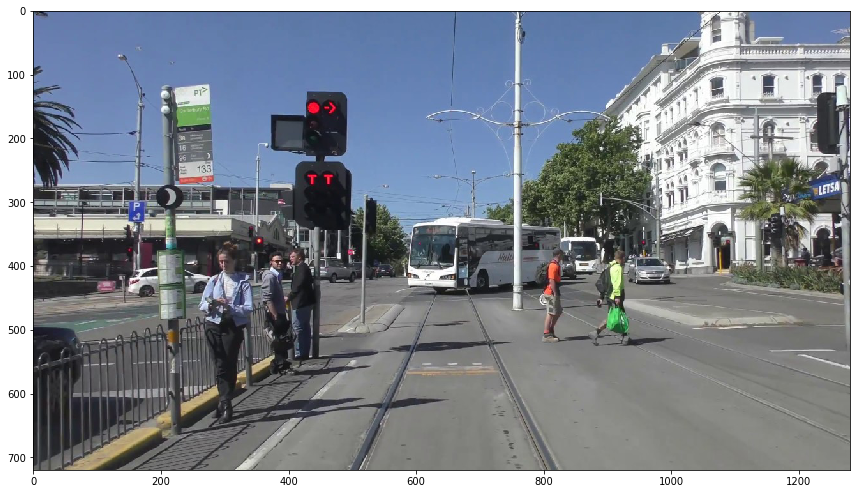

In [17]:
# # Load a random image from the images folder
image = skimage.io.imread('/root/Mask_RCNN/test.jpg')

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(image)

In [0]:
ROOT_DIR = os.getcwd()

VIDEO_IMAGE_DIR = '/root/Mask_RCNN/processedIMG'
VIDEO_SAVE_DIR = os.path.join(ROOT_DIR, 'NewVideo')
VIDEO_FILE_DIR = '/root/Mask_RCNN'
os.mkdir(VIDEO_SAVE_DIR)
os.mkdir(VIDEO_IMAGE_DIR)


Processing 1 images
image                    shape: (720, 1280, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


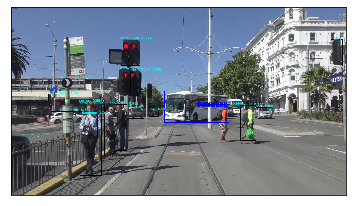

In [21]:
# Run detection
results = model.detect([image], verbose=1)
# # Visualize results
r = results[0]
display_results(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'],show_mask=False,display_img=True, save_dir= VIDEO_FILE_DIR,img_name = 'test1_out.jpg')

# plt.savefig('/root/Mask_RCNN/test3_Out.jpg',bbox_inches='tight', pad_inches=-0.5,orientation= 'landscape')

In [58]:
%cd

/root




---



---



---



---



In [0]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [60]:
pip install pytube

In [84]:
%cd /root/Mask_RCNN

/root/Mask_RCNN


In [0]:
#importing the module 
import pytube
  
#where to save 
# SAVE_PATH = "/content" #to_do 
  
#link of the video to be downloaded https://youtu.be/SuWEtGYhdQs
# link = "https://www.youtube.com/watch?v=h-lwT_1g3Ms"    # tram video
# link="https://www.youtube.com/watch?v=Y1jTEyb3wiI"
# link = "https://www.youtube.com/watch?v=_c0C5Hz7PsM"
link = "https://www.youtube.com/watch?v=6-a0cCO8nCM" 
try: 
    #object creation using YouTube which was imported in the beginning 
    yt =pytube.YouTube(link) 
except: 
    print("Connection Error") #to handle exception 
  
# #filters out all the files with "mp4" extension 
# mp4files = yt.filter('mp4') 
stream = yt.streams.first()
stream.download(filename='Downloaded_Video')  


In [0]:
# frame_count = 0
# batchSize = 1
# frames = []
# frameResetCount = 0
# capture = cv2.VideoCapture(os.path.join(VIDEO_FILE_DIR, 'Downloaded_Video.mp4'))    
# # while True:
# for ii in range(10):
#     ret, frame = capture.read()
#     # Bail out when the video file ends
#     if not ret:
#         print('broken')
#         break        
#     # Save each frame of the video to a list
#     frame_count += 1
#     frameResetCount +=1
#     # frames.append(frame)
#     # if len(frames) == batch_size:
#     print(frame.shape)
#     if frameResetCount == batchSize:
#         frameResetCount = 0 
#         results = model.detect(frame, verbose=0)
#         for i, item in enumerate(zip(frame, results)):
#             frame = item[0]
#             r = item[1]
#             print(frame_count)
#             name = '{0}.jpg'.format(frame_count + i - batch_size)
#             name = os.path.join(VIDEO_IMAGE_DIR, name)
#             display_results(frame, r['rois'], r['masks'], r['class_ids'], 
#                             class_names, r['scores'],show_mask=False,display_img=True,
#                             save_img=True, save_dir= VIDEO_IMAGE_DIR,img_name = name)
#             cv2.imwrite(name, frame)
#         # Clear the frames array to start the next batch
#     frames = []

In [0]:
frame_count = 0
frameResetCount = 0
batch_size = 10
frames = []
capture = cv2.VideoCapture(os.path.join(VIDEO_FILE_DIR, 'Downloaded_Video.mp4'))    
while True:
# for ii in range(200):
    ret, frame = capture.read()
    # Bail out when the video file ends
    if not ret:
        print('broken')
        break        
    # Save each frame of the video to a list
    
    frameResetCount +=1
    frames.append(frame)
    # if len(frames) == batch_size:
    if frameResetCount == batch_size :
        frameResetCount = 0
        frame_count += 1 
        results = model.detect(frames, verbose=0)
        for i, item in enumerate(zip(frames, results)):
          frame = item[0]
          r = item[1]
          print(frame_count)
          name = '{0}.jpg'.format(frame_count)
          name = os.path.join(VIDEO_IMAGE_DIR, name)
          display_results(frame, r['rois'], r['masks'], r['class_ids'], 
                          class_names, r['scores'],show_mask=False,display_img=False,
                          save_img=True,show_warning = False, save_dir= VIDEO_IMAGE_DIR,img_name = name)
          # cv2.imwrite(name, frame)
        # boxes = r['rois']
        # class_ids = r['class_ids']
        # scores = r['scores']
        # for i,b in enumerate(boxes[0]):
        #   print(class_ids)
        #   print(class_ids[i])
        #   if class_ids[i] == 3 or class_ids[i] == 6 or class_ids[i] == 8 or class_ids[i] ==1 :
        #     if scores[i]> 0.5 :
        #       mid_x = (boxes[i][3]+boxes[i][1])/2
        #       mid_y = (boxes[i][2]+boxes[i][0])/2
        #       # print(mid_x, mid_y)
        #       apx_distance = round((1-(boxes[i][3]-boxes[i][1]))**2,1)
        #       cv2.rectangle(frame, (boxes[i][1], boxes[i][0]), (boxes[i][3], boxes[i][2]), 1)
        #       if apx_distance >= 30000 and  apx_distance <=100000  :
        #         if mid_x > 0.3*1280 and mid_x < 0.7*1280:
        #           cv2.putText(frame, 'WARNING!!!', (int(mid_x), int(mid_y)), 
        #                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 3)
        #           cv2.rectangle(frame, (boxes[i][1], boxes[i][0]), (boxes[i][3], boxes[i][2]),(0,0,255), 1)
        #       elif apx_distance > 100000 :
        #         # print(int(mid_x-50), int(mid_y))
        #         cv2.putText(frame, 'WARNING!!!', (int(mid_x), int(mid_y)), 
        #                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 3)
        #         cv2.rectangle(frame, (boxes[i][1], boxes[i][0]), (boxes[i][3], boxes[i][2]),(0,0,255), 1)
                  # print('warned')
        # plt.imshow(frame)
        # plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
        # plt.show()
        # cv2.imwrite(os.path.join(VIDEO_IMAGE_DIR, name), frame)
        # Clear the frames array to start the next batch
    frames = []

In [40]:
print(mid_x, mid_y)

902.0 347.5


In [47]:

video = cv2.VideoCapture(os.path.join(VIDEO_FILE_DIR, 'Downloaded_Video.mp4')) 

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
fps = video.get(cv2.CAP_PROP_FPS)
print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))


Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.97002997002997


In [0]:
import glob

In [0]:
# Get all image file paths to a list.
images = list(glob.iglob(os.path.join(VIDEO_IMAGE_DIR, '*.*')))
# Sort the images by name index.
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))
images

In [0]:
img = cv2.imread(images[1])
np.shape(img)

In [0]:
def make_video(outvid, images=None, fps=6, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid


In [0]:
images2 = images[250:]
images2

In [74]:
%cd /root/Mask_RCNN

/root/Mask_RCNN


In [88]:
# Directory of images to run detection on
# ROOT_DIR = os.getcwd()
# VIDEO_IMAGE_DIR = '/root/Mask_RCNN/imagesFromVideo'
# VIDEO_SAVE_DIR = os.path.join(ROOT_DIR, "video/save")
# images = list(glob.iglob(os.path.join(VIDEO_IMAGE_DIR, '*.jpg')))
# # Sort the images by integer index
# images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join('/root/Mask_RCNN/out.mp4')
make_video(outvid, images=images[250:], fps=6, size=None,
               is_color=True, format="FMP4")

<VideoWriter 0x7fcfaa50a3d0>

In [0]:
from google.colab import files
files.download(outvid) 



---



---



---



---



---



# **LANE** **DETECTION**

In [10]:
%cd

/root


In [0]:
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

In [0]:
import numpy as np
# from PIL import ImageGrab
import cv2
import time


# def process_img(original_image):
#     processed_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
#     processed_img = cv2.Canny(processed_img, threshold1=200, threshold2=300)
#     return processed_img

# def main():
#     for i in list(range(4))[::-1]:
#         print(i+1)
#         time.sleep(1)

#     last_time = time.time()
#     while(True):
#         screen =  np.array(ImageGrab.grab(bbox=(0,40, 800, 640)))
#         new_screen = process_img(screen)
#         print('Loop took {} seconds'.format(time.time()-last_time))
#         last_time = time.time()
#         cv2.imshow('window', new_screen)
#         #cv2.imshow('window2', cv2.cvtColor(screen, cv2.COLOR_BGR2RGB))
#         if cv2.waitKey(25) & 0xFF == ord('q'):
#             cv2.destroyAllWindows()
#             break
def process_img(original_image):
    processed_img = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    processed_img = cv2.Canny(processed_img, threshold1=200, threshold2=300)
    
    # vertices = np.array([[200,700],[200,400],[400,300],[800,300],[1000,400],[1000,700],
                        #  ], np.int32)

    # processed_img = roi(processed_img, [vertices])
    
    return processed_img

def edges(image):
  gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  v = np.median(gray_img)
  sigma = 0.33
  lower = int(max(150,(1.0 - sigma)* v))
  upper = int(max(255,(1.0 + sigma)* v))
  return cv2.Canny(gray_img, lower, upper)
#HSV
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
#HLS
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)


# WHite Yellow 
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([0,200,0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    # lower = np.uint8([ 10,   0, 100])
    # upper = np.uint8([ 40, 255, 255])
    # yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    # mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = white_mask)
# white_yellow_images = list(map(select_white_yellow, test_images))

def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

In [0]:
def roi(img, vertices):
    #blank mask:
    mask = np.zeros_like(img)
    # fill the mask+

    cv2.fillPoly(mask, vertices, (255,)*3)
    # now only show the area that is the mask
    masked = cv2.bitwise_and(img, mask)
    return masked

In [0]:
image = skimage.io.imread('/root/Mask_RCNN/105.jpg')
# blank_image = np.zeros_like(image)
# hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
# canny_img = process_img(image)

vertices = np.array([[100,700],[400,400],[800,400],[1100,700]], np.int32)
vertices = np.array([[0,700],[0,400],[1280,400],[1280,700]], np.int32)
img  = roi(image, [vertices])
img =  edges(img)

img = select_white_yellow(image)
plt.imshow(img)
# print(canny_img.shape)
# plt.imshow(processed_IMG,cmap='gray')

In [13]:
%cd


/root


In [14]:
!git clone https://github.com/naokishibuya/car-finding-lane-lines

Cloning into 'car-finding-lane-lines'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Unpacking objects: 100% (66/66), done.


In [15]:
import matplotlib.pyplot as plt
import cv2
import os, glob
import numpy as np
from moviepy.editor import VideoFileClip

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3850240/45929032 bytes (8.4%)8126464/45929032 bytes (17.7%)12443648/45929032 bytes (27.1%)16564224/45929032 bytes (36.1%)20824064/45929032 bytes (45.3%)25141248/45929032 bytes (54.7%)29466624/45929032 bytes (64.2%)33677312/45929032 bytes (73.3%)37707776/45929032 bytes (82.1%)41975808/45929032 bytes (91.4%)45929032/45929032 bytes (100.0%)
  Done
File saved as /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1.


In [0]:
def show_images(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

In [0]:
test_images = [plt.imread(path) for path in glob.glob('/root/car-finding-lane-lines/test_images/solidWhiteRight.jpg')]

show_images(test_images)

In [0]:
# image is expected be in RGB color space
def select_rgb_white_yellow(image): 
    # white color mask
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower, upper)
    # yellow color mask
    lower = np.uint8([190, 190,   0])
    upper = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked = cv2.bitwise_and(image, image, mask = mask)
    return masked

show_images(list(map(select_rgb_white_yellow, test_images)))

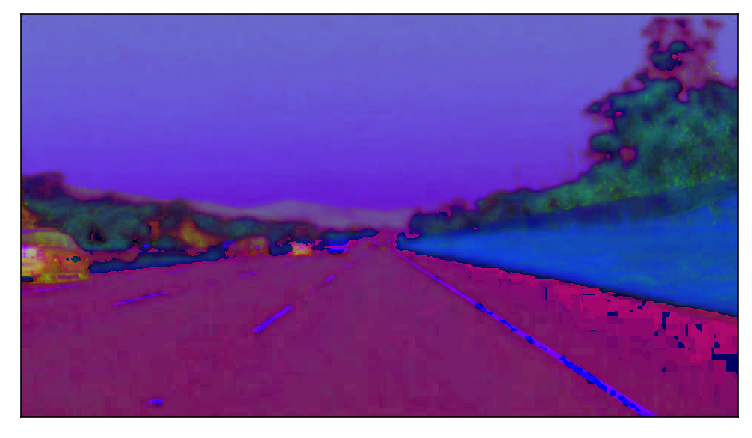

In [19]:
def convert_hsv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

show_images(list(map(convert_hsv, test_images)))

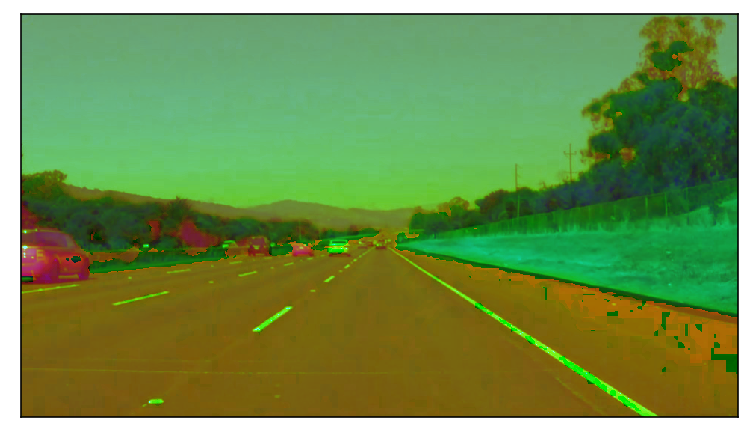

In [20]:
def convert_hls(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)

show_images(list(map(convert_hls, test_images)))

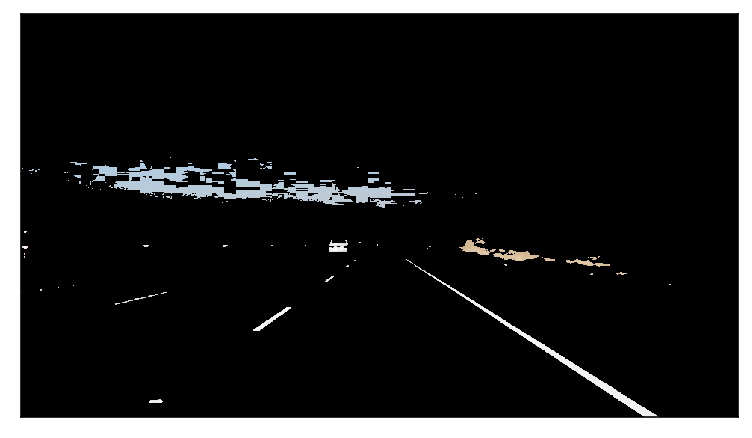

In [21]:
def select_white_yellow(image):
    converted = convert_hls(image)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(converted, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(converted, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

white_yellow_images = list(map(select_white_yellow, test_images))

show_images(white_yellow_images)

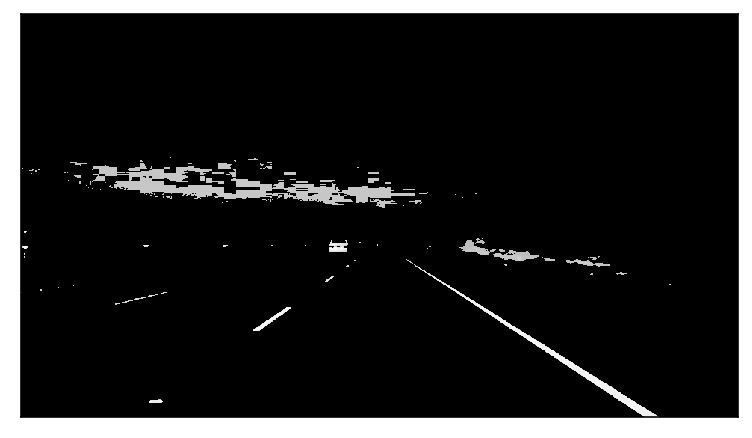

In [22]:
def convert_gray_scale(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

gray_images = list(map(convert_gray_scale, white_yellow_images))

show_images(gray_images)

In [0]:
def apply_smoothing(image, kernel_size=15):
    """
    kernel_size must be postivie and odd
    """
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

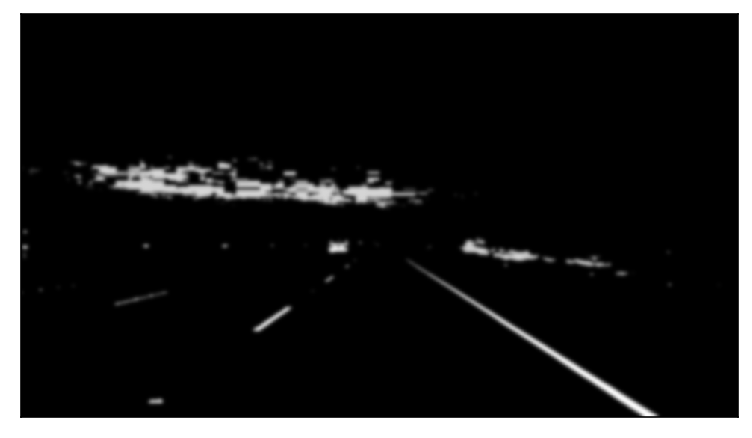

In [30]:
blurred_images = list(map(lambda image: apply_smoothing(image), gray_images))

show_images(blurred_images)

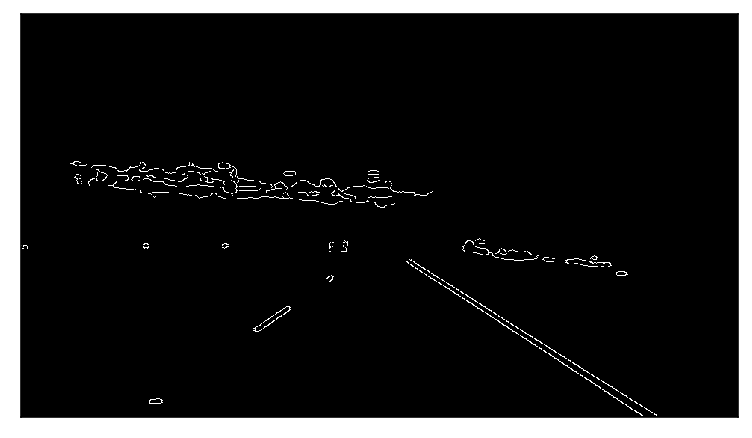

In [31]:
def detect_edges(image, low_threshold=50, high_threshold=150):
    return cv2.Canny(image, low_threshold, high_threshold)

edge_images = list(map(lambda image: detect_edges(image), blurred_images))

show_images(edge_images)

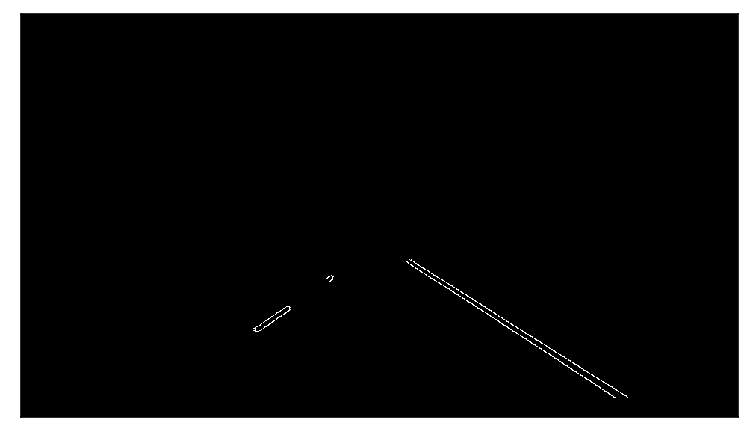

In [32]:
def filter_region(image, vertices):
    """
    Create the mask using the vertices and apply it to the input image
    """
    mask = np.zeros_like(image)
    if len(mask.shape)==2:
        cv2.fillPoly(mask, vertices, 255)
    else:
        cv2.fillPoly(mask, vertices, (255,)*mask.shape[2]) # in case, the input image has a channel dimension        
    return cv2.bitwise_and(image, mask)

    
def select_region(image):
    """
    It keeps the region surrounded by the `vertices` (i.e. polygon).  Other area is set to 0 (black).
    """
    # first, define the polygon by vertices
    rows, cols = image.shape[:2]
    bottom_left  = [cols*0.1, rows*0.95]
    top_left     = [cols*0.4, rows*0.6]
    bottom_right = [cols*0.9, rows*0.95]
    top_right    = [cols*0.6, rows*0.6] 
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    return filter_region(image, vertices)


# images showing the region of interest only
roi_images = list(map(select_region, edge_images))

show_images(roi_images)

In [0]:
def hough_lines(image):
    """
    `image` should be the output of a Canny transform.
    
    Returns hough lines (not the image with lines)
    """
    return cv2.HoughLinesP(image, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=300)


list_of_lines = list(map(hough_lines, roi_images))

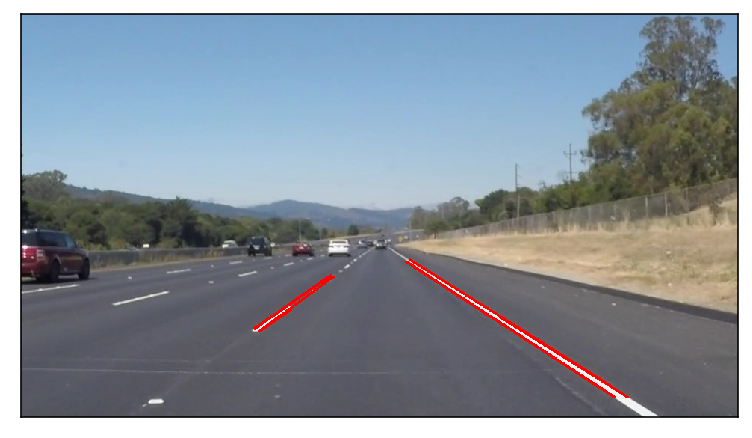

In [34]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2, make_copy=True):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    if make_copy:
        image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image


line_images = []
for image, lines in zip(test_images, list_of_lines):
    line_images.append(draw_lines(image, lines))
    
show_images(line_images)

In [0]:
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)

In [0]:
def make_line_points(y1, y2, line):
    """
    Convert a line represented in slope and intercept into pixel points
    """
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))

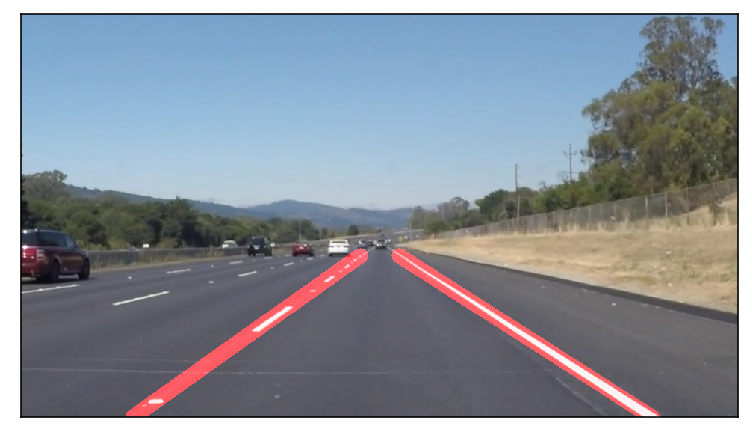

In [37]:
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)
             
    
lane_images = []
for image, lines in zip(test_images, list_of_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))

    
show_images(lane_images)

In [0]:
from collections import deque

QUEUE_LENGTH=50

# class LaneDetector:
#     def __init__(self):
#         self.left_lines  = deque(maxlen=QUEUE_LENGTH)
#         self.right_lines = deque(maxlen=QUEUE_LENGTH)

#     def process(self, image):
#         white_yellow = select_white_yellow(image)
#         gray         = convert_gray_scale(white_yellow)
#         smooth_gray  = apply_smoothing(gray)
#         edges        = detect_edges(smooth_gray)
#         regions      = select_region(edges)
#         lines        = hough_lines(regions)
#         left_line, right_line = lane_lines(image, lines)
        
#         def mean_line(line, lines):
#             if line is not None:
#                 lines.append(line)

#             if len(lines)>0:
#                 line = np.mean(lines, axis=0, dtype=np.int32)
#                 line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
#             return line

#         left_line  = mean_line(left_line,  self.left_lines)
#         right_line = mean_line(right_line, self.right_lines)

#         return draw_lane_lines(image, (left_line, right_line))

In [0]:
def process(image):
        white_yellow = select_white_yellow(image)
        gray         = convert_gray_scale(white_yellow)
        smooth_gray  = apply_smoothing(gray)
        edges        = detect_edges(smooth_gray)
        regions      = select_region(edges)
        lines        = hough_lines(regions)
        left_line, right_line = lane_lines(image, lines)
        Llines        = deque(maxlen=QUEUE_LENGTH)
        Rlines        = deque(maxlen=QUEUE_LENGTH)
        def mean_line(line, lines):
            if line is not None:
                lines.append(line)

            if len(lines)>0:
                line = np.mean(lines, axis=0, dtype=np.int32)
                line = tuple(map(tuple, line)) # make sure it's tuples not numpy array for cv2.line to work
            return line

        left_line  = mean_line(left_line,  Llines)
        right_line = mean_line(right_line, Rlines)

        return draw_lane_lines(image, (left_line, right_line))

In [39]:
# !pip install pytube

In [0]:
# #importing the module 
# import pytube
  
# #where to save 
# # SAVE_PATH = "/content" #to_do 
  
# #link of the video to be downloaded https://youtu.be/SuWEtGYhdQs
# # link = "https://www.youtube.com/watch?v=h-lwT_1g3Ms"    # tram video
# # link="https://www.youtube.com/watch?v=Y1jTEyb3wiI"
# # link = "https://www.youtube.com/watch?v=_c0C5Hz7PsM"
# link = "https://www.youtube.com/watch?v=6-a0cCO8nCM" 
# try: 
#     #object creation using YouTube which was imported in the beginning 
#     yt =pytube.YouTube(link) 
# except: 
#     print("Connection Error") #to handle exception 
  
# # #filters out all the files with "mp4" extension 
# # mp4files = yt.filter('mp4') 
# stream = yt.streams.first()
# stream.download(filename='Downloaded_Video')  

In [0]:
VIDEO_FILE_DIR = '/root/car-finding-lane-lines/test_videos'
VIDEO_IMAGE_DIR = '/root/savedIMG'

In [0]:
frames = []
frameResetCount = 0
frame_count = 0
batch_size = 2
capture = cv2.VideoCapture(os.path.join(VIDEO_FILE_DIR, 'solidWhiteRight.mp4'))    
while True:
# for ii in range(5):
    ret, frame = capture.read()
    # Bail out when the video file ends
    if not ret:
        print('broken')
        break        
    # Save each frame of the video to a list
    frameResetCount +=1
    frames.append(frame)
    # if len(frames) == batch_size:
    if frameResetCount == batch_size :
        frameResetCount = 0
        frame_count += 1 
        # frame = frames[0]
        print(frame_count)
        name = '{0}.jpg'.format(frame_count)
        name = os.path.join(VIDEO_IMAGE_DIR, name)
        processed_frame = process(frame)
        cv2.imwrite(os.path.join(VIDEO_IMAGE_DIR, name), processed_frame)
        # plt.imshow(processed_frame)

In [0]:
images = list(glob.iglob(os.path.join(VIDEO_IMAGE_DIR, '*.*')))
# Sort the images by name index.
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))
images

In [0]:
def make_video(outvid, images=None, fps=15, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid


In [71]:
outvid = os.path.join('/root/out.mp4')
make_video(outvid, images=images, fps=15, size=None,
               is_color=True, format="FMP4")

<VideoWriter 0x7f1a82047050>